# Medical Risk Classification Data

The objective of this analysis is predictive: to develop a classification model that identifies patients who are at high risk for cardiovascular complications. By doing so, healthcare providers can proactively intervene with targeted education, monitoring, or treatment plans. The analysis also seeks to maintain a balance between accuracy and explainability, ensuring that medical teams can trust and understand the model's decisions.

###🧑‍⚕️ Target Stakeholders
- Chief Medical Officer – wants interpretable risk factors for treatment planning.

- Health Operations Director – needs insights to allocate resources for high-risk patients.

- Data Science Lead – values modeling rigor, metrics, and fairness.

## Setup

In [ ]:
!pip install python-dotenv google-api-python-client

from google.colab import drive
drive.mount('/content/drive')

import os
from dotenv import load_dotenv
load_dotenv("/content/drive/MyDrive/Professional/Portfolio/Medical Risk Classification/.envs/.env_github")
github_pat = os.getenv("GITHUB_PAT")
print(f"✅ GITHUB_PAT loaded successfully")
if not github_pat:
    raise ValueError("❌ Error: 'GITHUB_PAT' is missing or invalid in your .env file.")

!git clone https://{github_pat}@github.com/vmagdale2/Medical-Risk-Classification.git

import sys
sys.path.append('/content/Medical-Risk-Classification.git/')
%cd /content/Deep-Learning-Classification-Captions/
!pwd
!ls

Mounted at /content/drive
✅ GITHUB_PAT loaded successfully
Cloning into 'Medical-Risk-Classification'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), 14.34 KiB | 14.34 MiB/s, done.
[Errno 2] No such file or directory: '/content/Deep-Learning-Classification-Captions/'
/content
/content
drive  Medical-Risk-Classification  sample_data


In [ ]:
import pandas as pd
import numpy as np
import random

## Data Generation

For the sake of the objectives of the project, I will be generating a **synthetic dataset** in Python. It will be labeled as "**Medical Risk Classification Data**" and will generate 1,000 patient records with features designed to allow for modeling, interpretability techniques, and imbalance handling strategies.

Below, data is generated using numpy random and the risk score is defined along with the probability of risk (*using Sigmoid transformation*) then converted into a dataframe.

In [ ]:
np.random.seed(42)
n = 1000
data = {
    'patientID': [f'P{i:04d}' for i in range(1, n+1)],
    'Age': np.random.randint(18, 90, n),
    'Sex': np.random.choice(['Male', 'Female'], n),
    'BMI': np.round(np.random.normal(28, 5, n), 1),
    'Smoker': np.random.choice(['Yes', 'No'], n, p=[0.2, 0.8]),
    'Hypertension': np.random.choice(['Yes', 'No'], n, p=[0.3, 0.7]),
    'Diabetes': np.random.choice(['Yes', 'No'], n, p=[0.15, 0.85]),
    'CholesterolLevel': np.round(np.random.normal(200, 35, n), 1),
    'PhysicalActivityLevel': np.random.choice(['Low', 'Medium', 'High'], n, p=[0.4, 0.4, 0.2]),
    'AlcoholConsumption': np.random.choice(['None', 'Moderate', 'Heavy'], n, p=[0.3, 0.6, 0.1]),
    'RecentHospitalVisit': np.random.choice(['Yes', 'No'], n, p=[0.25, 0.75]),
    'FamilyHistory': np.random.choice(['Yes', 'No'], n, p=[0.35, 0.65]),
}

In [ ]:
risk_score = (
    0.03 * data['Age'] +
    0.05 * (data['BMI']) +
    15 * np.array(data['Smoker'] == 'Yes').astype(int) +
    10 * np.array(data['Hypertension'] == 'Yes').astype(int) +
    12 * np.array(data['Diabetes'] == 'Yes').astype(int) +
    0.03 * data['CholesterolLevel'] +
    10 * np.array(data['PhysicalActivityLevel'] == 'Low').astype(int) +
    8 * np.array(data['AlcoholConsumption'] == 'Heavy').astype(int) +
    6 * np.array(data['RecentHospitalVisit'] == 'Yes').astype(int) +
    9 * np.array(data['FamilyHistory'] == 'Yes').astype(int)
)

In [ ]:
prob_risk = 1 / (1 + np.exp(-(risk_score - 140)/20))

In [ ]:
data['HighRisk'] = np.where(np.random.rand(n) < prob_risk, 'Yes', 'No')

In [ ]:
df = pd.DataFrame(data)
df.head()

,patientID,Age,Sex,BMI,Smoker,Hypertension,Diabetes,CholesterolLevel,PhysicalActivityLevel,AlcoholConsumption,RecentHospitalVisit,FamilyHistory,HighRisk
0,P0001,69,Male,35.7,No,Yes,No,220.1,Medium,Moderate,Yes,No,No
1,P0002,32,Male,37.0,Yes,Yes,Yes,195.6,Low,Moderate,No,No,No
2,P0003,89,Female,24.6,No,No,No,166.2,Low,Moderate,No,No,No
3,P0004,78,Male,29.4,Yes,No,No,190.7,Low,None,No,No,No
4,P0005,38,Male,21.4,No,No,No,165.4,Medium,Moderate,No,No,No


## 🩺 Medical Risk Classification Dataset: Data Dictionary



| Column Name             | Description |
|-------------------------|-------------|
| `PatientID`             | Unique identifier for each patient |
| `Age`                   | Patient age (18–90 years) |
| `Sex`                   | Patient sex: Male or Female |
| `BMI`                   | Body Mass Index (continuous, normal distribution with ~28 mean) |
| `Smoker`                | Whether the patient smokes (`Yes`/`No`) |
| `Hypertension`          | Diagnosis of hypertension (`Yes`/`No`) |
| `Diabetes`              | Diagnosis of diabetes (`Yes`/`No`) |
| `CholesterolLevel`      | Serum cholesterol level (normal distribution ~200 mean) |
| `PhysicalActivityLevel` | Categorical: `Low`, `Medium`, or `High` activity levels |
| `AlcoholConsumption`    | Categorical: `None`, `Moderate`, or `Heavy` alcohol use |
| `RecentHospitalVisit`   | Whether patient visited a hospital in the last 12 months (`Yes`/`No`) |
| `FamilyHistory`         | Whether the patient has a family history of chronic conditions (`Yes`/`No`) |
| `HighRisk`              | **Target** variable indicating whether the patient is at high risk for cardiovascular complications (`Yes`/`No`) |

### Notes:
- `HighRisk` is the binary classification target with slight class imbalance (~20-30% "Yes").


In [ ]:
output_path = '/content/drive/My Drive/Professional/Portfolio/Medical Risk Classification/Data/medical_risk_data.csv'
df.to_csv(output_path, index=False)
print(f"✅ DataFrame saved as CSV to: {output_path}")

✅ DataFrame saved as CSV to: /content/drive/My Drive/Professional/Portfolio/Medical Risk Classification/Data/medical_risk_data.csv


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patientID              1000 non-null   object 
 1   Age                    1000 non-null   int64  
 2   Sex                    1000 non-null   object 
 3   BMI                    1000 non-null   float64
 4   Smoker                 1000 non-null   object 
 5   Hypertension           1000 non-null   object 
 6   Diabetes               1000 non-null   object 
 7   CholesterolLevel       1000 non-null   float64
 8   PhysicalActivityLevel  1000 non-null   object 
 9   AlcoholConsumption     1000 non-null   object 
 10  RecentHospitalVisit    1000 non-null   object 
 11  FamilyHistory          1000 non-null   object 
 12  HighRisk               1000 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 101.7+ KB


,Age,BMI,CholesterolLevel
count,1000.000000,1000.000000,1000.000000
mean,52.881000,28.064400,200.636700
std,20.958915,4.918594,34.228352
min,18.000000,11.200000,98.700000
25%,34.750000,24.700000,176.975000
50%,52.500000,28.200000,200.000000
75%,71.000000,31.400000,223.600000
max,89.000000,41.500000,341.800000


# Data Cleaning

- No missing values are expected in synthetic data
- Range verification
- Removed outliers from BMI and Cholesterol levels
- One-hot encoded categories for `PhysicalActivityLevel`, `AlcoholConsumpsion`, etc.
### Feature Engineering
1. BMI category
2. Co-morbidity score
### Encoding
1. One-hot encoding for multi-category variables
  - `PhysicalActivityLevel`
  - `AlcoholConsumption`
  - `Sex`
2. Binary encoding for other variables
  - `Smoker`
  - `Hypertention`
  - `Diabetes`
  - `RecentHispitalVisit`
  - `FamilyHistory`
  - `HighRisk`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [ ]:
df['HighRisk'].value_counts()

,count
HighRisk,
No,996
Yes,4


In [ ]:
df.isnull().sum()

,0
patientID,0
Age,0
Sex,0
BMI,0
Smoker,0
Hypertension,0
Diabetes,0
CholesterolLevel,0
PhysicalActivityLevel,0
AlcoholConsumption,0


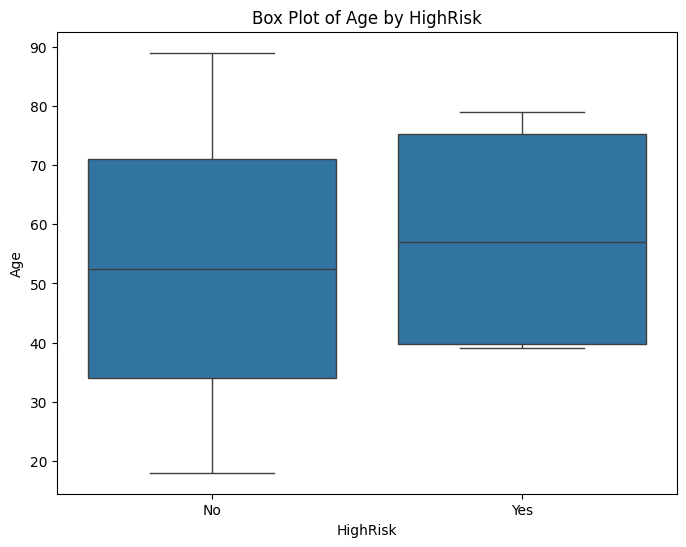

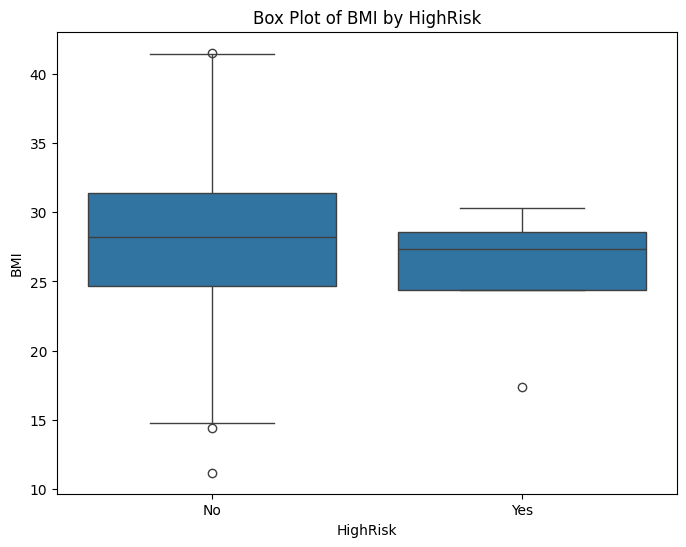

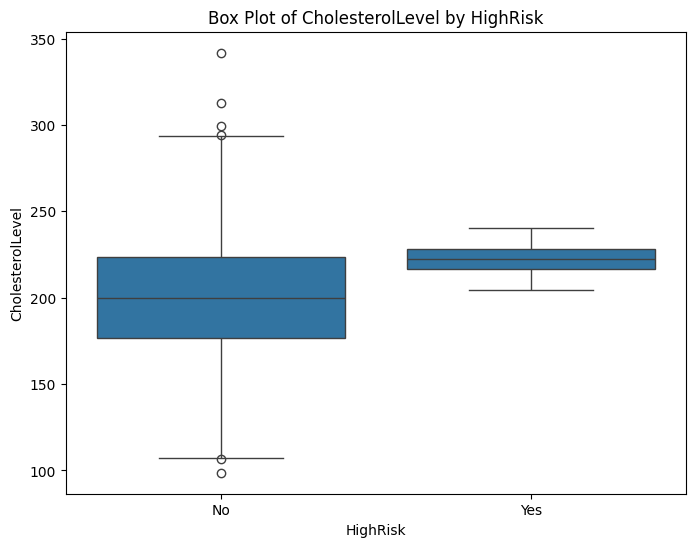

In [ ]:
numerical_features = ['Age', 'BMI', 'CholesterolLevel']

for feature in numerical_features:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x='HighRisk', y=feature, data=df)
  plt.title(f'Box Plot of {feature} by HighRisk')
  plt.show()

In [ ]:
def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_filtered

df_filtered = remove_outliers_iqr(df, 'BMI')
df_filtered = remove_outliers_iqr(df_filtered, 'CholesterolLevel')

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_filtered.shape}")

Original DataFrame shape: (1000, 13)
DataFrame shape after removing outliers: (992, 13)


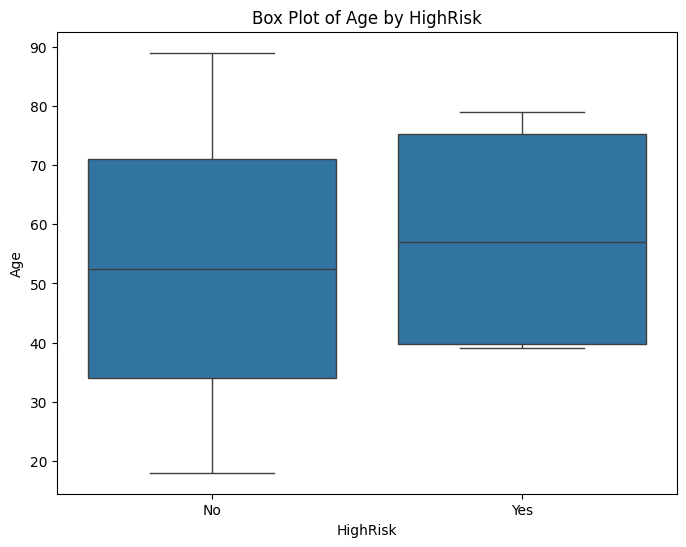

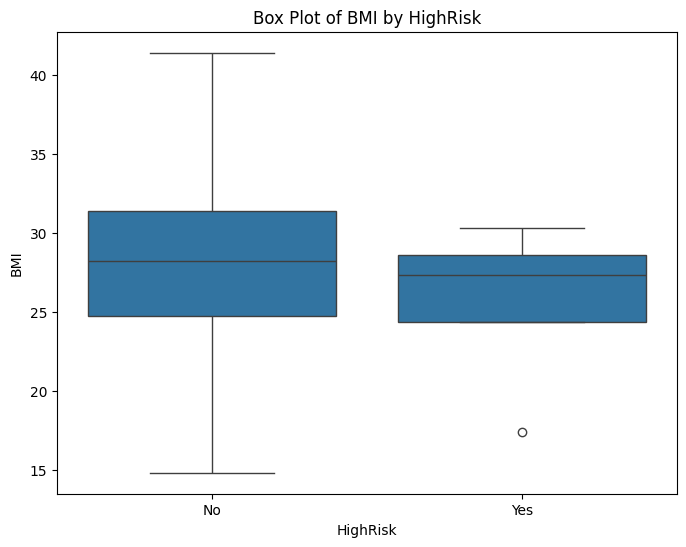

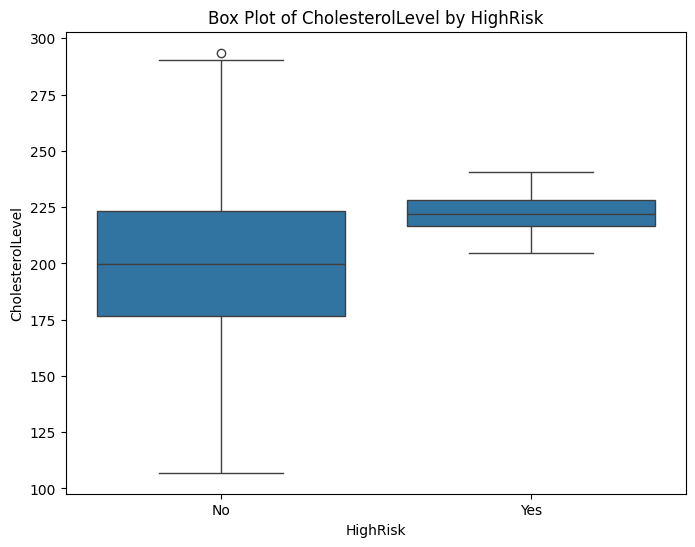

In [ ]:
numerical_features = ['Age', 'BMI', 'CholesterolLevel']

for feature in numerical_features:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x='HighRisk', y=feature, data=df_filtered)
  plt.title(f'Box Plot of {feature} by HighRisk')
  plt.show()

In [ ]:
df_feature_engineering = df_filtered.copy()

def bmi_category(bmi):
  if bmi < 18.5:
    return 'Underweight'
  elif bmi < 25:
    return 'Normal'
  elif bmi < 30:
    return 'Overweight'
  else:
    return 'Obese'

df_feature_engineering['BMI Category'] = df_feature_engineering['BMI'].apply(bmi_category)

df_feature_engineering['Comorbidity Score'] = (
    df_feature_engineering['Hypertension'].apply(lambda x: 1 if x == 'Yes' else 0) +
    df_feature_engineering['Diabetes'].apply(lambda x: 1 if x == 'Yes' else 0) +
    df_feature_engineering['Smoker'].apply(lambda x: 1 if x == 'Yes' else 0)
)

df_feature_engineering.head()

,patientID,Age,Sex,BMI,Smoker,Hypertension,Diabetes,CholesterolLevel,PhysicalActivityLevel,AlcoholConsumption,RecentHospitalVisit,FamilyHistory,HighRisk,BMI Category,Comorbidity Score
0,P0001,69,Male,35.7,No,Yes,No,220.1,Medium,Moderate,Yes,No,No,Obese,1
1,P0002,32,Male,37.0,Yes,Yes,Yes,195.6,Low,Moderate,No,No,No,Obese,3
2,P0003,89,Female,24.6,No,No,No,166.2,Low,Moderate,No,No,No,Normal,0
3,P0004,78,Male,29.4,Yes,No,No,190.7,Low,None,No,No,No,Overweight,1
4,P0005,38,Male,21.4,No,No,No,165.4,Medium,Moderate,No,No,No,Normal,0


`BMI Category` will be added to the one-hot encoding list.

`Comorbidity Score` will be added to the binary encoding list.

In [ ]:
df_encoded = df_feature_engineering.copy()
categorical_features = ['Sex', 'PhysicalActivityLevel', 'AlcoholConsumption', 'BMI Category']

for feature in categorical_features:
  df_encoded = pd.get_dummies(df_encoded, columns=[feature], prefix=[feature])

binary_features = ['Smoker', 'Hypertension', 'Diabetes', 'RecentHospitalVisit', 'FamilyHistory', 'HighRisk']

label_encoder = LabelEncoder()

for feature in binary_features:
  df_encoded[feature] = label_encoder.fit_transform(df_encoded[feature])

df_encoded.head()

,patientID,Age,BMI,Smoker,Hypertension,Diabetes,CholesterolLevel,RecentHospitalVisit,FamilyHistory,HighRisk,...,PhysicalActivityLevel_High,PhysicalActivityLevel_Low,PhysicalActivityLevel_Medium,AlcoholConsumption_Heavy,AlcoholConsumption_Moderate,AlcoholConsumption_None,BMI Category_Normal,BMI Category_Obese,BMI Category_Overweight,BMI Category_Underweight
0,P0001,69,35.7,0,1,0,220.1,1,0,0,...,False,False,True,False,True,False,False,True,False,False
1,P0002,32,37.0,1,1,1,195.6,0,0,0,...,False,True,False,False,True,False,False,True,False,False
2,P0003,89,24.6,0,0,0,166.2,0,0,0,...,False,True,False,False,True,False,True,False,False,False
3,P0004,78,29.4,1,0,0,190.7,0,0,0,...,False,True,False,False,False,True,False,False,True,False
4,P0005,38,21.4,0,0,0,165.4,0,0,0,...,False,False,True,False,True,False,True,False,False,False


# Handling Class Imbalances

- Defining X and y
- printing class distribution
- Applying SMOTE

In [46]:
X = df_encoded.drop(['patientID', 'HighRisk'], axis=1)
y = df_encoded['HighRisk']

In [47]:
y.value_counts(normalize=True)

,proportion
HighRisk,
0,0.995968
1,0.004032


In [49]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled).value_counts(normalize=True))

HighRisk
0    0.5
1    0.5
Name: proportion, dtype: float64


In [50]:
y_resampled = pd.Series(y_resampled, name='HighRisk')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42)

In [55]:
from google.colab import files
train_data_path = '/content/drive/My Drive/Professional/Portfolio/Medical Risk Classification/Data/train_data.csv'
test_data_path = '/content/drive/My Drive/Professional/Portfolio/Medical Risk Classification/Data/test_data.csv'

X_train.to_csv(train_data_path, index=False)
X_test.to_csv(test_data_path, index=False)

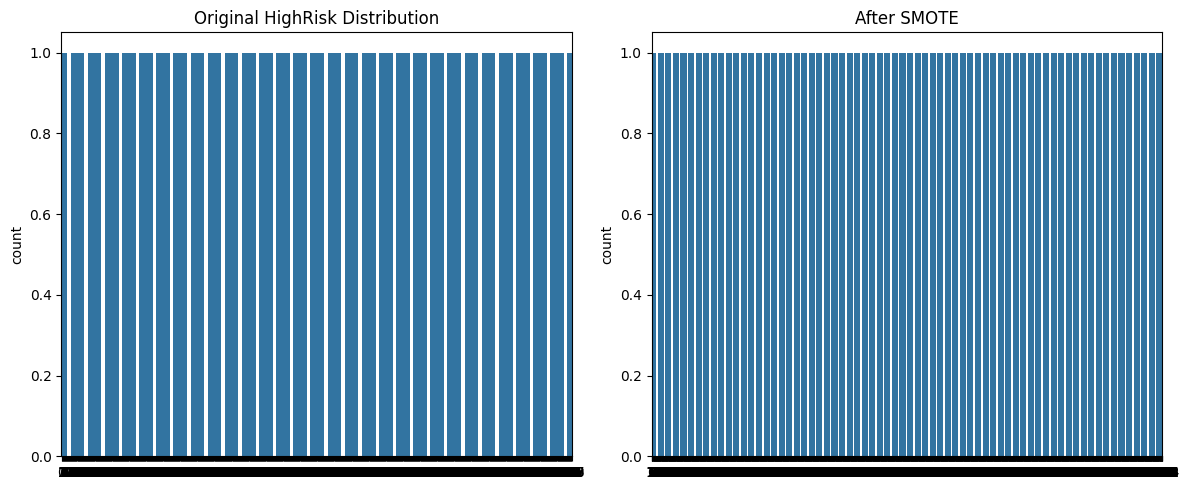

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(y, ax=ax[0])
ax[0].set_title('Original HighRisk Distribution')
sns.countplot(y_resampled, ax=ax[1])
ax[1].set_title('After SMOTE')
plt.tight_layout()
plt.show()

In [54]:
try:
  X_train_df = pd.DataFrame(X_train)
  y_train_df = pd.DataFrame(y_train)
  X_test_df = pd.DataFrame(X_test)
  y_test_df = pd.DataFrame(y_test)
except:
  print('X_train, y_train, X_test, y_test are not Pandas dataframes.')

output_dir = '/content/drive/My Drive/Professional/Portfolio/Medical Risk Classification/Data/'
X_train_path = os.path.join(output_dir, 'X_train.csv')
y_train_path = os.path.join(output_dir, 'y_train.csv')
X_test_path = os.path.join(output_dir, 'X_test.csv')
y_test_path = os.path.join(output_dir, 'y_test.csv')

X_train_df.to_csv(X_train_path, index=False)
y_train_df.to_csv(y_train_path, index=False)
X_test_df.to_csv(X_test_path, index=False)
y_test_df.to_csv(y_test_path, index=False)